# MAGPIE tutorial on SMA mouse brain sample

We showcase how to run the MAGPIE pipeline on one sample from *Spatial multimodal analysis of transcriptomes and metabolomes in tissues* by Marco Vicari, Reza Mirzazadeh, Anna Nilsson et al, published in Nature Communications (https://www.nature.com/articles/s41587-023-01937-y). 

## Input format 

The directory from which you run the pipeline should have the following general structure:

    ├── Snakefile
    ├── magpie_shiny_app.py
    ├── figures  
    │   ├── magpie_logo.png
    ├── scripts
    │   ├── alter_data.py
    │   ├── create_mock_spaceranger.py
    │   ├── create_perbarcode_matrix.py
    ├── input
    │   ├── (optional) exclude.txt
    │   ├── (optional) selected.txt
    │   ├── ... 

As described in more detail in our documentation, for an individual sample the inputs should follow this structure:

    [sample name]
    ├── visium                               # Spaceranger outputs
    │   ├── filtered_feature_bc_matrix.h5
    │   ├── spatial
    │   │   ├── aligned_fiducials.jpg
    │   │   ├── detected_tissue_image.jpg
    │   │   ├── scalefactors_json.json
    │   │   ├── tissue_hires_image.png
    │   │   ├── tissue_lores_image.png
    │   │   ├── tissue_positions_list.csv
    ├── msi                    
    │   ├── MSI_intensities.csv              # Table of intensities with MSI peaks on columns and pixels on rows
    │   ├── MSI_metadata.csv                 # Table of metadata about MSI pixels, including x and y coordinate columns
    │   │── MSI_HE.[jpg,png,tiff]            # (OPTIONAL) intermediate MSI image to assist with coregistration
    ├── landmarks_MSI2HE.csv                 # (OPTIONAL) Table of identified landmarks between MSI image and MSI H&E image
    ├── landmarks_MSI2HE.csv                 # (OPTIONAL) Table of identified landmarks between MSI H&E and Visium H&E image
    └── landmarks_noHE.csv                   # (OPTIONAL) Table of identified landmarks between MSI image and Visium H&E

For this dataset we do not have an intermediate MSI image available so we will follow the 'noHE' version of the pipeline.

The Visium data is saved in the Space Ranger format and the MSI data is separated into a metadata file containing spot_id, x and y coordinates and an intensity table with pixels/spots on the rows and peaks on the columns. The first column of both tables should be the ID of each pixel, in the same order in both cases. 

The metadata and intensity tables for this sample are shown below:

In [4]:
import pandas as pd

meta = pd.read_csv('input/V11L12-038_D1/msi/MSI_metadata.csv')
meta[:5]

,spot_id,x,y
0,pixel_14,-14,67
1,pixel_15,-15,67
2,pixel_16,-16,67
3,pixel_17,-17,67
4,pixel_18,-18,67


In [5]:
intensities = pd.read_csv('input/V11L12-038_D1/msi/MSI_intensities.csv')
intensities.iloc[:5,:5]

,spot_id,mz-108.901945,mz-108.902095,mz-109.02966,mz-109.07286
0,pixel_14,194565.2656,147422.4375,107558.41410,0.00000
1,pixel_15,585243.8750,386686.1875,93422.78125,0.00000
2,pixel_16,268511.0000,199858.3125,140381.84380,79260.86719
3,pixel_17,346582.0938,285972.9375,117012.73440,0.00000
4,pixel_18,487304.3750,354217.7188,29423.32617,8445.78418


This spatial shape of the data can be plotted out:

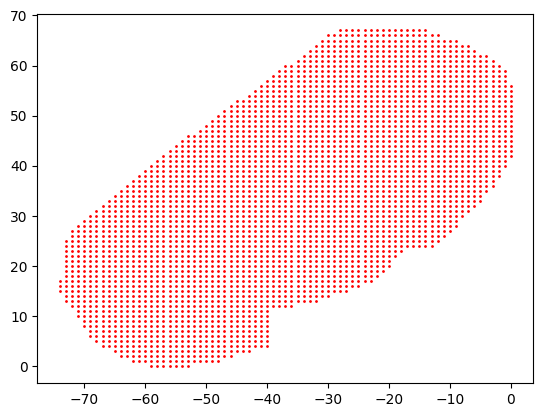

In [11]:
import matplotlib.pyplot as plt

plt.scatter(x=meta['x'],y=meta['y'],s=1,c='r')

## Landmark selection through MAGPIE shiny app

After navigating in command line to the outer directory described above containing the magpie_shiny_app.py script, you can launch the app by running: 

After running this line, you will be prompted to open the app in a browser which will look like this:

![app_options](figures/first_app_view.png)

In order to identify useful landmarks for coregistration from the MSI data itself, we need to identify a way to represent the data where morphological features can be found and mapped to corresponding features in the Visium H&E image. This could be achieved through the first principal component (i.e. the strongest source of variability within the dataset), through a combination of the first 3 principal components or using individual features which are known to mark patterns of interest. Such dimensionality reduction can be run on all features (peaks) or on other a subset of interest according to user preference. In this case we will use the first PC (the PC1 option) on all features (default if no peaks are individually selected) as our representation which gives us the following:

![app_options](figures/pc1_representation.png)

As expected, the app identified that no intermediate H&E image from the MSI section was provided so we are only shown the MSI data itself and the Visium H&E image. Using this representation we can see several similarities between the two sections which will allow to identify useful landmarks for coregistration. We can save this dimensionality reduction to help us assess the coregistration later using the 'Save MSI colouring for later analysis' button which will save a table to *input/[sample_name]/msi/MSI_dimreduction.csv*.

After selecting an appropriate dimensionality reduction, we can start choosing landmarks between the two sections for coregistration which will be overlaid on the images:

![app_options](figures/landmark_selection.png)

You can select as many landmarks as you wish but we recommend to aim for at least 10 as our benchmarking showed improved performed when additional landmarks before 10. The landmarks you have selected will be shown in a table like below. Make sure to press the 'Download landmarks' button when you're finished which will save the landmarks to be used by the snakemake pipeline.

![app_options](figures/landmark_table.png)

This is everything you need to move onto the snakemake pipeline. If you'd prefer to use landmarks identified through another method (e.g. an automated method like ELD) just make sure you save them in the same format as used by the MAGPIE shiny app, so you have a file called input/[sample_name]/landmarks_noHE.csv if you do not have an intermediate MSI image like in this example or files input/[sample_name]/landmarks_MSI2HE.csv and input/[sample_name]/landmarks_HE2HE.csv if you do. In our example the resulting file will look like:

```
X_left,Y_left,X_right,Y_right
-43.392404913273495,30.714144841259213,990.5500732301224,1098.4644936810546
-51.68596463501392,37.950035028777826,816.7284008300779,929.8816862543379
-32.804881864243185,51.00993439161629,1290.787507375654,613.7889223292436
-18.33526703056841,25.772561298563573,1638.430852175743,1209.0969610548377
-61.03827666165736,39.258097458857044,606.0354645875999,896.1032592825652
-40.39260671604824,6.07889367218634,1090.6292179452998,1681.0669563632155
-54.68576283223918,15.785575631052776,706.114609302777,1459.8020216156497
-45.68636824056341,53.22119047946254,974.7481030119368,558.3177033800923
-13.041505506053255,24.27762972938811,1749.0446437030444,1248.4535712832144
-11.100459613731026,47.52174636781049,1764.84661392123,781.1324907502565
```

## Coregistration with MAGPIE snakemake pipeline

Now that you have identified and saved landmarks for the coregistration, the remaining aspects of the coregistration pipeline can be performed using the MAGPIE snakemake workflow. 

From the same working directory as shown above, you can find a file called Snakefile which describes the pipeline and the parameters for each stage

```  
include_barcode_matrix = True

if os.path.isfile('input/selected.txt'):
    file = open("input/selected.txt", "r")
    samples = [line.rstrip() for line in file]
else:
    samples = glob_wildcards("input/{sample}/msi").sample
if os.path.isfile('input/exclude.txt'):
    file = open("input/exclude.txt", "r")
    samples = list(set(samples).difference(set([line.rstrip() for line in file])))

if include_barcode_matrix:
    output_file = "spaceranger_aggregated"
else:
    output_file = "spaceranger"
    
rule all:
    input:
        expand("output/{sample}/"+output_file+"/filtered_feature_bc_matrix.h5", sample=samples)
        
rule check_inputs:
    message:
        'Checking inputs.'
    conda: 'magpie'
    input:
        "input/"
    output:
        "output/summary.csv"
    params:
        verbose = True
    script:
        "scripts/check_inputs.py"

rule perform_coreg:
    message:
        "Performing co-registration."
    conda: 'magpie'
    input:
        "input/{sample}/msi/MSI_metadata.csv",
        "output/summary.csv"
    output:
        "output/{sample}/transformed.csv",
        "output/{sample}/transformed.png"
    params:
        no_HE_transform = 'affine',
        MSI2HE_transform = 'affine',
        HE2HE_transform = 'TPS',
        sample = "{sample}",
        verbose = True
    script:
        "scripts/alter_data.py"

rule make_spaceranger:
    message:
        "Creating spaceranger formatted output."
    conda: 'magpie'
    input:
        "output/{sample}/transformed.csv",
        "output/{sample}/transformed.png"
    output:
        "output/{sample}/spaceranger/filtered_feature_bc_matrix.h5"
    params:
        sample = "{sample}",
        verbose = True
    script:
        "scripts/create_mock_spaceranger.py"

rule create_barcode_matrix:
    message:
        "Generating aggregated data."
    conda: 'magpie'
    input:
        "output/{sample}/spaceranger/filtered_feature_bc_matrix.h5"
    output:
        "output/{sample}/spaceranger_aggregated/filtered_feature_bc_matrix.h5"
    params:
        sample = "{sample}",
        agg_fn = 'mean',
        verbose = True,
        only_within_tissue = False
    script:
        "scripts/create_perbarcode_matrix.py"
```

Each 'rule' specifies a different stage of the pipeline and they are executed in the order

<code> check_inputs </code> -> <code> perform_coreg </code> -> <code> make_spaceranger </code> -> <code> create_barcode_matrix </code>

### Parameter selection

There are several user-selected parameters to be aware of in this file:
1) <code> include_barcode_matrix = False </code> specifies whether or not the final stage of the pipeline, where MSI observations are aggregated to form matching observations to Visium barcodes so that 1:1 mappings can be identified across both modalities. This stage is optional but can be very useful for downstream analysis. This part of the pipeline is the most time demanding so you may choose to run the pipeline without the step initially to check the success of the coregistration. The same step can also be performed within the semla package using the <code> CreateMultiModalObject </code> function.
   
2) Within each stage you can set <code> verbose = True/False </code> to get more or less information about the different stages of the process as they are being executed.
   
3) In the <code> perform_coreg </code> stage, a set of 3 parameters can be used <code> no_HE_transform </code>, <code> MSI2HE_transform  </code> and <code> HE2HE_transform </code>, each of which can be set to 'affine' or 'TPS' depending on whether you want to use a linear or non-linear transformation. We discuss in the manuscript the different circumstances where each choice can be advantageous. In this example, only the <code> no_HE_transform </code> will be used as we do not have an intermediate MSI image and it is set here to affine. Because we have both measurements taken from the same tissue section, it may make sense to choose a linear transformation as we will only see small alterations between sections rather than large deformations.

4) In the <code> create_barcode_matrix </code> step, the <code> agg_fn </code> parameter specifies how MSI observations (for each pixel) will be aggregated to form a single observation per Visium barcode. The options are 'mean' or 'sum' and in this case we will use the mean.

5) Finally, in <code> create_barcode_matrix </code> you can choose whether only Visium barcodes within the tissue are returned or whether to not perform filtering at this stage. 

Once all of these parameters have been set, you can run the pipeline! 

### Running the snakemake workflow

From within the same working directory, you can use the same following line to run the pipeline:

```
snakemake -j [number of cores]
```

The command line output will look something like this for this dataset:

```
Building DAG of jobs...
Using shell: /bin/bash
Provided cores: 1 (use --cores to define parallelism)
Rules claiming more threads will be scaled down.
Conda environments: ignored
Job stats:
job                      count
---------------------  -------
all                          1
check_inputs                 1
create_barcode_matrix        1
make_spaceranger             1
perform_coreg                1
total                        5

Select jobs to execute...

[Mon Feb 24 10:13:07 2025]
Job 4: Checking inputs.
Reason: Missing output files: output/summary.csv

Working on sample V11L12-038_D1
Checking for intermediate MSI image...
Checking metadata and intensity tables exist and can be read...
Checking metadata contains spot_id, x and y columns...
Checking intensity table begins with metadata column...
Checking spot_id columns in metadata and intensity table match exactly
Storing dimensions and examples of data
Summary saved to output/summary.csv
[Mon Feb 24 10:13:17 2025]
Finished job 4.
1 of 5 steps (20%) done
Select jobs to execute...

[Mon Feb 24 10:13:17 2025]
Job 3: Performing co-registration.
Reason: Missing output files: output/V11L12-038_D1/transformed.png, output/V11L12-038_D1/transformed.csv; Input files updated by another job: output/summary.csv

No MSI H&E image identified.
Mapping MSI data to Visium H&E
Using affine transform to map MSI data to Visium H&E
Saving Visium H&E with new MSI coordinates overlaid...
Saving new MSI coordinates...
[Mon Feb 24 10:13:22 2025]
Finished job 3.
2 of 5 steps (40%) done
Select jobs to execute...

[Mon Feb 24 10:13:22 2025]
Job 2: Creating spaceranger formatted output.
Reason: Missing output files: output/V11L12-038_D1/spaceranger/filtered_feature_bc_matrix.h5; Input files updated by another job: output/V11L12-038_D1/transformed.png, output/V11L12-038_D1/transformed.csv

[Mon Feb 24 10:13:40 2025]
Finished job 2.
3 of 5 steps (60%) done
Select jobs to execute...

[Mon Feb 24 10:13:40 2025]
Job 1: Generating aggregated data.
Reason: Missing output files: output/V11L12-038_D1/spaceranger_aggregated/filtered_feature_bc_matrix.h5; Input files updated by another job: output/V11L12-038_D1/spaceranger/filtered_feature_bc_matrix.h5

Calculating distances between MSI pixels and Visium spots...
Grouping MSI pixels by Visium spot...
Number of MSI pixels matching to Visium spots: 2388
Number of Visium spots matching to MSI pixels: 2371
Number of MSI pixels not matching to Visium spots: 696
Number of Visium spots not matching to MSI pixels: 2621
Aggregating MSI pixels per Visium spot by mean...
Copying Visium coordinates which map to some MSI pixels...
The new MSI coordinate file has been saved, containing 2371 spots/pixels.
Creating JSON file...
Copying tissue image...
Spaceranger 'spatial' folder content ready!
Reading MSI peak data file...
Preparing MSI peak data...
Writing new feature-barcode matrix data...
Spaceranger 'filtered_feature_bc_matrix' folder content ready!
Writing filtered_feature_bc_matrix.h5 file...
Spaceranger 'filtered_feature_bc_matrix.h5' file ready!
Mock Space Ranger output completed for sample at path output/V11L12-038_D1/spaceranger_aggregated/
[Mon Feb 24 10:16:55 2025]
Finished job 1.
4 of 5 steps (80%) done
Select jobs to execute...

[Mon Feb 24 10:16:55 2025]
localrule all:
    input: output/V11L12-038_D1/spaceranger_aggregated/filtered_feature_bc_matrix.h5
    jobid: 0
    reason: Input files updated by another job: output/V11L12-038_D1/spaceranger_aggregated/filtered_feature_bc_matrix.h5
    resources: tmpdir=/var/folders/vb/gvs9l8xj3q10l987dbjg2bkw0000gq/T

[Mon Feb 24 10:16:55 2025]
Finished job 0.
5 of 5 steps (100%) done
Complete log: .snakemake/log/2025-02-24T101307.169550.snakemake.log
```

We will now describe each of the outputs in turn corresponding to each stage of the pipeline.

#### i) Input checking

The output from the input checking stage (<code> check_inputs </code>) is a file output/summary.csv which looks like this:

In [21]:
summary = pd.read_csv('output/summary.csv')
summary

,Subfolder,MSI image,Num pixels,Name of first pixel,Num peaks,Name of first peak
0,V11L12-038_D1,NaN,3084,pixel_14,3658,mz-108.901945


In this case, we ran the pipeline with only one sample but if we included multiple samples then they would all be shown as separate rows. The information we can get from this table is:

- For sample V11L12-038_D1 there is no intermediate MSI image. If there was, the name of the file would be listed in the MSI image column
- There are 3084 MSI pixels and the first one is called pixel_14
- There are 3658 peaks in the MSI dataset and the first one is called mz-108.901945

This summary can help you see if the pipeline has correctly interpreted the structure of the data and that is has correctly assessed the presence of an intermediate MSI image. If it has not, you may need to alter the input structure according to the description above. This step will check the format more generally, making sure that all necessary files are included and readable and follow the right structure as required for subsequent steps.

#### ii) Coregistration

The output from the coregistration stage (<code> perform_coreg </code>) is:

- *transformed.csv* containing the newly mapped MSI coordinates which will now be in a comparable space to the Visium data
- *transformed.png* which is the resulting H&E image after mapping (in this case it will just be the original Visium image but if we had an intermediate MSI image it would be the adjusted version of this after coregistration)
- *transformed_withCoords_VisiumHE.png* overlays the transformed MSI coordinates onto the Visium H&E image so you can assess whether the coordinates overlap as you expect

In [24]:
transformed = pd.read_csv('output/V11L12-038_D1/transformed.csv')
transformed[:5]

,spot_id,x,y
0,pixel_14,1735.755610,271.844118
1,pixel_15,1711.620147,271.225193
2,pixel_16,1687.484684,270.606269
3,pixel_17,1663.349221,269.987345
4,pixel_18,1639.213758,269.368421


This table contains the (x,y) coordinates for MSI pixel in the Visium coordinate space. We can see these then directly overlaid onto the Visium H&E image itself:

![overlaidVisium](output/V11L12-038_D1/transformed_withCoords_VisiumHE.png)

As this MSI data was segmented to mostly contained only the actual tissue itself, we can see quite close overlap of the new MSI coordinates and the Visium data, suggesting the coregistration looks quite successful!

#### iii) Saving in Space Ranger format

In order to aid compatability with a large number of downstream analysis options, we opted to save the transformed MSI data into a Space Ranger output style so any tool which had support for Visium could be used. The output of this stage is a folder named *spaceranger* which follows the standard structure, namely a *filtered_feature_bc_matrix.h5* and *spatial* folder.

You can read the object using standard approaches like in scanpy, Seurat or semla, for example:

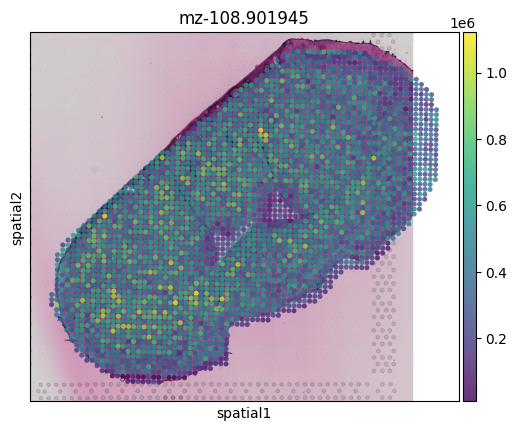

In [41]:
import scanpy as sc
msi_obj = sc.read_visium('output/V11L12-038_D1/spaceranger/',library_id='myLib')
sc.pl.spatial(msi_obj, img_key="hires", color='mz-108.901945',alpha=0.8)

#### iii) Aggregating MSI pixels to match Visium barcodes

The final stage of the pipeline creates expanded Visium spots (such that there are no gaps between spots) and aggregates the MSI pixels within each expanded Visium spot so that MSI pixels can be directly mapped to Visium spots. By default the mean of peak intensities for all pixels within a given expanded Visium spot radius is used but the sum can also be used. This output is also saved into a Space Ranger-style output and can be read in the same manner:

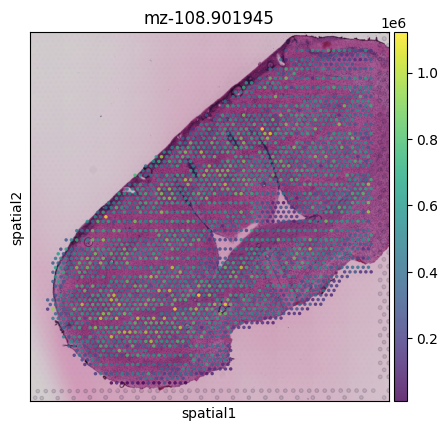

In [42]:
import scanpy as sc
msi_agg_obj = sc.read_visium('output/V11L12-038_D1/spaceranger_aggregated/',library_id='myLib')
sc.pl.spatial(msi_agg_obj, img_key="hires", color='mz-108.901945',alpha=0.8)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


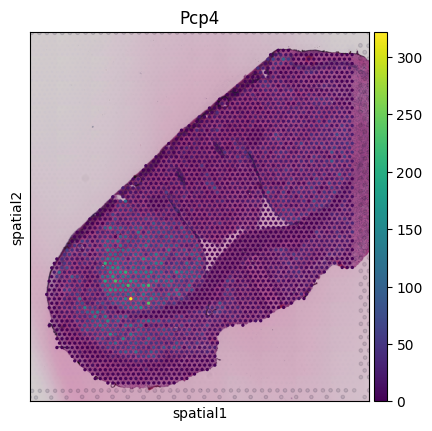

In [47]:
import scanpy as sc
visium_obj = sc.read_visium('input/V11L12-038_D1/visium/',library_id='myLib')
sc.pl.spatial(visium_obj, img_key="hires", color='Pcp4')

For this dataset, we can see that because the MSI resolution is lower than for Visium, not every Visium spot has a corresponding MSI pixel. In other examples we see that multiple MSI pixels correspond to the same Visium spot. 

Due to the matching observations, metabolomics and transcriptomics measurements can then be directly correlated or used as input to multi-omics methods such as MOFA as demonstrated within our manuscript *Spatially resolved integrative analysis of transcriptomic and metabolomic changes 
in tissue injury studie*s


For extra understanding, you can also find the Visium barcodes and the MSI pixels which are assigned to that barcode in *output/V11L12-038_D1/matched_Visium_MSI_IDs.csv*

In [50]:
matched = pd.read_csv('output/V11L12-038_D1/matched_Visium_MSI_IDs.csv')
matched[:5]

,visium_spot,MSI_spot
0,CGTCTCTCGCCGAGGC-1,MSI_V11L12-038_D1_pixel_14
1,AACCCGATAGGGCTTC-1,MSI_V11L12-038_D1_pixel_15
2,TGATGCTCACGTAGTC-1,MSI_V11L12-038_D1_pixel_16
3,CGGGCTACTTAAATTG-1,MSI_V11L12-038_D1_pixel_17
4,CTGAAACGGCCCTCAG-1,MSI_V11L12-038_D1_pixel_18
